In [1]:
import torch
from torch import nn


class Generator(nn.Module):
    def __init__(self, input_dim=10, image_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim

        self.gen = nn.Sequential(
            self._generator_block(input_dim, hidden_dim * 4),
            self._generator_block(
                hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1
            ),
            self._generator_block(hidden_dim * 2, hidden_dim),
            self._generator_block(
                hidden_dim, image_channel, kernel_size=4, final_layer=True
            ),
        )

    def _generator_block(
        self,
        input_channels,
        output_channels,
        kernel_size=3,
        stride=2,
        final_layer=False,
    ):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(
                    input_channels, output_channels, kernel_size, stride
                ),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(
                    input_channels, output_channels, kernel_size, stride
                ),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)


def create_noise_vector(n_samples, input_dim, device="cpu"):
    return torch.randn(n_samples, input_dim, device=device)


class Discriminator(nn.Module):
    def __init__(self, image_channel=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self._discriminator_block(image_channel, hidden_dim),
            self._discriminator_block(hidden_dim, hidden_dim * 2),
            self._discriminator_block(hidden_dim * 2, 1, final_layer=True),
        )

    def _discriminator_block(
        self,
        input_channels,
        output_channels,
        kernel_size=4,
        stride=2,
        final_layer=False,
    ):

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [2]:
import torch
from torch import nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F

torch.manual_seed(0)  # Set for our testing purposes, please do not change!


def plot_images_from_tensor(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    """
    Plots a grid of images from a given tensor.

    The function first scales the image tensor to the range [0, 1]. It then detaches the tensor from the computation
    graph and moves it to the CPU if it's not already there. After that, it creates a grid of images and plots the grid.

    Args:
        image_tensor (torch.Tensor): A 4D tensor containing the images.
            The tensor is expected to be in the shape (batch_size, channels, height, width).
        num_images (int, optional): The number of images to include in the grid. Default is 25.
        size (tuple, optional): The size of a single image in the form of (channels, height, width). Default is (1, 28, 28).
        nrow (int, optional): Number of images displayed in each row of the grid. The final grid size is (num_images // nrow, nrow). Default is 5.
        show (bool, optional): Determines if the plot should be shown. Default is True.

    Returns:
        None. The function outputs a plot of a grid of images.
    """

    # Normalize the image tensor to [0, 1]
    image_tensor = (image_tensor + 1) / 2

    # Detach the tensor from its computation graph and move it to the CPU
    image_unflat = image_tensor.detach().cpu()

    # Create a grid of images using the make_grid function from torchvision.utils
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)

    # Plot the grid of images
    # The permute() function is used to rearrange the dimensions of the grid for plotting
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

    # Show the plot if the 'show' parameter is True
    if show:
        plt.show()

    



""" The reason for doing "image_grid.permute(1, 2, 0)"

PyTorch modules processing image data expect tensors in the format C × H × W.

Whereas PILLow and Matplotlib expect image arrays in the format H × W × C

so to use them with matplotlib you need to reshape it
to put the channels as the last dimension:

I could have used permute() method as well like below
"np.transpose(npimg, (1, 2, 0))"

------------------

Tensor.detach() is used to detach a tensor from the current computational graph. It returns a new tensor that doesn't require a gradient.

When we don't need a tensor to be traced for the gradient computation, we detach the tensor from the current computational graph.

We also need to detach a tensor when we need to move the tensor from GPU to CPU.

"""


def weights_init(m):
    """
    Initialize the weights of convolutional and batch normalization layers.

    Args:
        m (torch.nn.Module): Module instance.

    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


def ohe_vector_from_labels(labels, n_classes):
    return F.one_hot(labels, num_classes=n_classes)


"""
x = torch.tensor([4, 3, 2, 1, 0])
F.one_hot(x, num_classes=6)

# Expected result
# tensor([[0, 0, 0, 0, 1, 0],
#         [0, 0, 0, 1, 0, 0],
#         [0, 0, 1, 0, 0, 0],
#         [0, 1, 0, 0, 0, 0],
#         [1, 0, 0, 0, 0, 0]])
"""


""" Concatenation of Multiple Tensor with `torch.cat()` - RULE - To concatenate WITH torch.cat(), where the list of tensors are concatenated across the specified dimensions, requires 2 conditions to be satisfied

1. All tensors need to have the same number of dimensions and
2. All dimensions except the one that they are concatenated on, need to have the same size. """


def concat_vectors(x, y):
    """
    Concatenate two tensors along the second dimension.

    Args:
        x (torch.Tensor): First input tensor.
        y (torch.Tensor): Second input tensor.

    Returns:
        torch.Tensor: Concatenated tensor.

    """
    combined = torch.cat((x.float(), y.float()), 1)
    return combined

def calculate_input_dim(z_dim, mnist_shape, n_classes):
    """
    Calculate the input dimensions for the generator and discriminator networks.

    Args:
        z_dim (int): Dimension of the random noise vector (latent space).
        mnist_shape (tuple): Shape of the MNIST images, e.g., (1, 28, 28).
        n_classes (int): Number of classes in the dataset.

    Returns:
        tuple: Tuple containing the generator input dimension and discriminator image channel.

    mnist_shape = (1, 28, 28)
    n_classes = 10"""
    generator_input_dim = z_dim + n_classes

    # mnist_shape[0] is 1 as its grayscale images
    discriminator_image_channel = mnist_shape[0] + n_classes

    return generator_input_dim, discriminator_image_channel

In [3]:
import torch
import torch.nn as nn

#from utils import *

####################################################
def test_weights_init():
    # Create a sample model with Conv2d and BatchNorm2d layers
    model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3),
        nn.BatchNorm2d(16),
        nn.ConvTranspose2d(16, 3, kernel_size=3),
        nn.BatchNorm2d(3)
    )

    # Initialize the model weights
    model.apply(weights_init)

    # Check the weights of Conv2d layers
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            assert torch.allclose(module.weight.mean(), torch.tensor(0.0), atol=0.02)
            assert torch.allclose(module.weight.std(), torch.tensor(0.02), atol=0.02)

    # Check the weights of BatchNorm2d layers
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            assert torch.allclose(module.weight.mean(), torch.tensor(0.0), atol=0.02)
            assert torch.allclose(module.weight.std(), torch.tensor(0.02), atol=0.02)
            assert torch.allclose(module.bias, torch.tensor(0.0))

    print("Unit test passed!")

# Run the unit test
# test_weights_init()

####################################################
def test_concat_vectors():
    # Create sample input tensors
    x = torch.tensor([[1, 2, 3], [4, 5, 6]])
    y = torch.tensor([[7, 8, 9], [10, 11, 12]])

    # Perform concatenation
    combined = concat_vectors(x, y)

    # Check the output type and shape
    assert isinstance(combined, torch.Tensor)
    assert combined.shape == (2, 6)  # Expected shape after concatenation

    # Check the values in the concatenated tensor
    expected_combined = torch.tensor([[1, 2, 3, 7, 8, 9], [4, 5, 6, 10, 11, 12]])
    assert torch.allclose(combined, expected_combined)

    print("Unit test passed!")

# Run the unit test
# test_concat_vectors()

####################################################
def test_calculate_input_dim():
    # Set up sample inputs
    z_dim = 100
    mnist_shape = (1, 28, 28)
    n_classes = 10

    # Calculate input dimensions
    generator_input_dim, discriminator_image_channel = calculate_input_dim(z_dim, mnist_shape, n_classes)

    # Check the output types and values
    assert isinstance(generator_input_dim, int)
    assert generator_input_dim == z_dim + n_classes

    assert isinstance(discriminator_image_channel, int)
    assert discriminator_image_channel == mnist_shape[0] + n_classes

    print("Unit test passed!")

# Run the unit test
# test_calculate_input_dim()


In [4]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

#from conditional_gan import *
#from utils import *


mnist_shape = (1, 28, 28)
n_classes = 10


criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = "cuda"

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, pickle_path, transform=None):
        with open(pickle_path, 'rb') as f:
            self.images = pickle.load(f)  # Load the 3D NumPy array (shape: [N, H, W])

        self.transform = transform

        # Ensure images are in the correct format (convert to float32 and normalize if needed)
        self.images = self.images.astype(np.float32)

        # If images are grayscale but missing a channel, add one (PyTorch expects [C, H, W])
        if len(self.images.shape) == 3:  # Shape: (N, H, W)
            self.images = np.expand_dims(self.images, axis=1)  # Shape: (N, 1, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Shape: (1, H, W)

        if self.transform:
            image = self.transform(image)

        return image  # If labels exist, return (image, label)

# Define transformations (if needed)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert NumPy array to PyTorch tensor (already normalized)
])



In [11]:
# Path to your pickle file
pickle_path = "../ZafrensData/final_dataset/images_34K.pkl"

# Create dataset and dataloader
dataset = CustomImageDataset(pickle_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Test dataloader
for batch in dataloader:
    print(batch.shape)  # Should print (batch_size, 1, H, W)
    break

torch.Size([64, 340, 1, 340])


In [7]:

dataloader = DataLoader(
    MNIST(
        "/home/dennis00/scRNA_GAN/MNIST", download=True, transform=transform
    ),
    batch_size=batch_size,
    shuffle=True,
)


In [8]:
generator_input_dim, discriminator_image_channel = calculate_input_dim(
    z_dim, mnist_shape, n_classes
)

gen = Generator(input_dim=generator_input_dim).to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator(image_channel=discriminator_image_channel).to(device)

disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)


In [9]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


gen = gen.apply(weights_init)

disc = disc.apply(weights_init)


In [10]:

cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False


In [11]:
for epoch in range(0, 1):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

  0%|          | 0/469 [00:00<?, ?it/s]

In [13]:

real.shape


torch.Size([96, 1, 28, 28])

In [14]:
labels

tensor([5, 7, 6, 3, 1, 2, 8, 1, 6, 9, 9, 0, 9, 6, 8, 4, 7, 1, 9, 6, 7, 7, 0, 2,
        4, 1, 1, 8, 1, 3, 1, 1, 0, 3, 0, 3, 0, 7, 4, 1, 4, 6, 7, 3, 3, 7, 2, 1,
        5, 1, 7, 6, 2, 5, 9, 1, 7, 7, 9, 6, 0, 1, 0, 8, 2, 3, 2, 4, 4, 5, 1, 0,
        6, 5, 4, 9, 0, 2, 6, 5, 6, 7, 0, 5, 4, 4, 9, 8, 9, 0, 0, 8, 4, 3, 9, 0])

In [16]:

one_hot_labels = ohe_vector_from_labels(labels.to(device), n_classes)
print("one_hot_labels ", one_hot_labels.size())  # => torch.Size([128, 10])


one_hot_labels  torch.Size([96, 10])


In [17]:
image_one_hot_labels = one_hot_labels[:, :, None, None]
print(
    "image_one_hot_labels.size ", image_one_hot_labels.size()
)  # => torch.Size([128, 10, 1, 1])

image_one_hot_labels = image_one_hot_labels.repeat(
    1, 1, mnist_shape[1], mnist_shape[2]
)
print(
    "image_one_hot_labels.size ", image_one_hot_labels.size()
)

image_one_hot_labels.size  torch.Size([96, 10, 1, 1])
image_one_hot_labels.size  torch.Size([96, 10, 28, 28])


In [18]:

disc_opt.zero_grad()
# Get noise corresponding to the current batch_size
fake_noise = create_noise_vector(cur_batch_size, z_dim, device=device)


In [27]:

fake_noise.shape


torch.Size([96, 64])

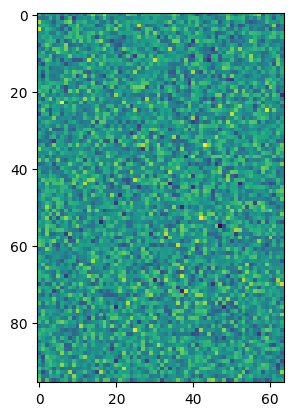

In [29]:
plt.imshow(fake_noise.detach().cpu())

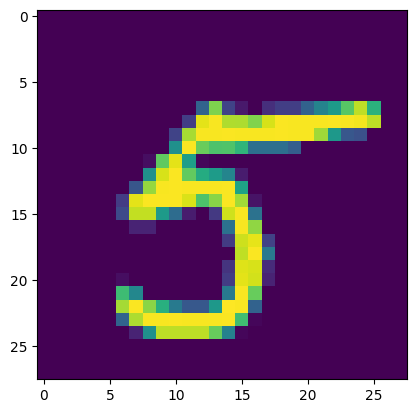

In [34]:
plt.imshow(real.detach().cpu()[0, 0, :, :])

In [24]:

noise_and_labels = concat_vectors(fake_noise, one_hot_labels)
fake             = gen(noise_and_labels)


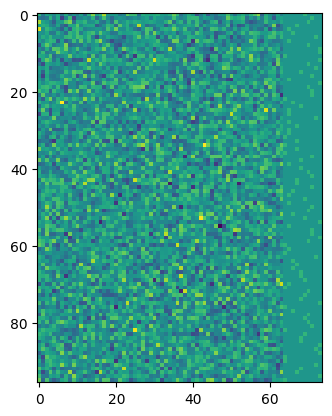

In [30]:

plt.imshow(noise_and_labels.detach().cpu())


In [26]:

noise_and_labels.shape


torch.Size([96, 74])

In [ ]:

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        # create one hot encoded vectors from labels and n_classes
        one_hot_labels = ohe_vector_from_labels(labels.to(device), n_classes)
        print("one_hot_labels ", one_hot_labels.size())  # => torch.Size([128, 10])

        """ The above ([128, 10]) need to be converted to ([128, 10, 28, 28])

        Because, Concatenation of Multiple Tensor with `torch.cat()` - RULE - To concatenate WITH torch.cat(), where the list of tensors are concatenated across the specified dimensions, requires 2 conditions to be satisfied

         1. All tensors need to have the same number of dimensions and
         2. All dimensions except the one that they are concatenated on, need to have the same size.

        To do that, first I am adding extra dimension with 'None'
        the easiest way to add extra dimensions to an array is by using the keyword None,
        when indexing at the position to add the extra dimension.
        Note, in below with keyword None, I am only adding extra dummy empty dimension

        a = torch.rand(1, 2)
        ic(a) # => tensor([[0.1749, 0.6387]])
        ic(a[None, :]) # => tensor([[[0.1749, 0.6387]]])

        a = torch.rand([1,2,3,4])
        ic(a.shape) # => torch.Size([1, 2, 3, 4])
        ic(a[None, :].shape) # => torch.Size([1, 1, 2, 3, 4])
        """
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        print(
            "image_one_hot_labels.size ", image_one_hot_labels.size()
        )  # => torch.Size([128, 10, 1, 1])

        image_one_hot_labels = image_one_hot_labels.repeat(
            1, 1, mnist_shape[1], mnist_shape[2]
        )
        print(
            "image_one_hot_labels.size ", image_one_hot_labels.size()
        )  # => torch.Size([128, 10, 28, 28])

        #########################
        #  Train Discriminator
        #########################
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size
        fake_noise = create_noise_vector(cur_batch_size, z_dim, device=device) # Will take in RNASeq data

        # Now we can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images

        noise_and_labels = concat_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)

        # Make sure that enough images were generated
        assert len(fake) == len(real)

        # Now we can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels,
        #              remember to detach the generator (.detach()) so we do not backpropagate
        #              through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred

        # Combine the fake images with image_one_hot_labels
        fake_image_and_labels = concat_vectors(fake, image_one_hot_labels)

        # Combine the real images with image_one_hot_labels
        real_image_and_labels = concat_vectors(real, image_one_hot_labels)

        # Get the discriminator's prediction on the reals and fakes
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)

        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)

        # Calculate Discriminator Loss on fakes and reals
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        # Get average Discriminator Loss
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Backpropagate and update weights
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        #########################
        #  Train Generators
        #########################

        gen_opt.zero_grad()

        fake_image_and_labels = concat_vectors(fake, image_one_hot_labels)
        # This will error if we didn't concatenate wer labels to wer image correctly
        disc_fake_pred = disc(fake_image_and_labels)

        """ Now calculate Generator Loss and note that, here, unlike the disc_loss, with
        disc_fake_pred, I am passing a vector containing its elements as 1 with torch.ones_like
        Because, Generator wants to fool the Discriminator by telling it that all these fake images are actually real, i.e. with value of 1
        """
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

        # Backpropagate and update weights
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        ##################################
        #  Log Progress and Visualization
        #  for each display_step = 50
        ##################################
        if cur_step % display_step == 0 and cur_step > 0:
            # Calculate Generator Mean loss for the latest display_steps (i.e. latest 50 steps)
            # list[-x:]   # last x items in the array
            gen_mean = sum(generator_losses[-display_step:]) / display_step

            # Calculate Discriminator Mean loss for the latest display_steps (i.e. latest 50 steps)
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(
                f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}"
            )

            # Plot both the real images and fake generated images
            plot_images_from_tensor(fake)
            plot_images_from_tensor(real)

            step_bins = 20
            x_axis = sorted(
                [i * step_bins for i in range(len(generator_losses) // step_bins)]
                * step_bins
            )
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples])
                .view(-1, step_bins)
                .mean(1),
                label="Generator Loss",
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples])
                .view(-1, step_bins)
                .mean(1),
                label="Discriminator Loss",
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Let Long Training Continue")
        cur_step += 1